In [1]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Naive Bayes classifier to perform QPSK symbol detection

In [2]:
# Number of QPSK symbols to be transmitted.
N = 1000000

In [3]:
# Instantiate a Gaussian naive Bayes classifier for each one of the parts of a QPSK symbol.
gnb_Re = GaussianNB()
gnb_Im = GaussianNB()

In [4]:
# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

SER_simu = np.zeros(len(EsN0dB))
SER_theo = np.zeros(len(EsN0dB))
for idx in range(0,len(EsN0dB)):
    
    print('Es/N0 dB:', EsN0dB[idx])
    
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate QPSK symbols.
    ip =(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0) + 1j*(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0)
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    
   # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    # Split array into random train and test subsets.
    ip_Re_test, ip_Re_train, y_Re_test, y_Re_train = train_test_split(ip.real, y.real, random_state=42)
    
    ip_Im_test, ip_Im_train, y_Im_test, y_Im_train = train_test_split(ip.imag, y.imag, random_state=42)
    
    # Fit model for real part.
    gnb_Re.fit(y_Re_train, ip_Re_train.ravel())
    
    # Fit model for imaginary parts.
    gnb_Im.fit(y_Im_train, ip_Im_train.ravel())
    
    # Prediction for real part.
    detected_ip_Re = gnb_Re.predict(y_Re_test)
    detected_ip_Re = detected_ip_Re.reshape(len(y_Re_test), 1)
    
    # Prediction for imaginary part.
    detected_ip_Im = gnb_Im.predict(y_Im_test)
    detected_ip_Im = detected_ip_Im.reshape(len(y_Im_test), 1)    
        
    # Simulated QPSK BER.
    error_Re = (ip_Re_test != detected_ip_Re)
    error_Im = (ip_Im_test != detected_ip_Im)
    error = 0;
    for i in range(0, len(ip_Re_test)): 
        if(error_Re[i]==True or error_Im[i]==True): 
            error = error + 1
    
    SER_simu[idx] = 1.0 * error / len(ip_Re_test)
    
    # Theoretical QPSK BER.    
    SER_theo[idx] = erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0;


Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [5]:
# Print values of Es/N0 vs. SER.
for i in range(0,len(SER_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], SER_simu[i]))

Es/N0:-2 	- SER: 3.815000e-01
Es/N0:0 	- SER: 2.925360e-01
Es/N0:2 	- SER: 1.966427e-01
Es/N0:4 	- SER: 1.094133e-01
Es/N0:6 	- SER: 4.540000e-02
Es/N0:8 	- SER: 1.208133e-02
Es/N0:10 	- SER: 1.573333e-03
Es/N0:12 	- SER: 6.133333e-05
Es/N0:14 	- SER: 1.333333e-06
Es/N0:16 	- SER: 0.000000e+00
Es/N0:18 	- SER: 0.000000e+00
Es/N0:20 	- SER: 0.000000e+00


## Theorical vs. Simulated SER curves 

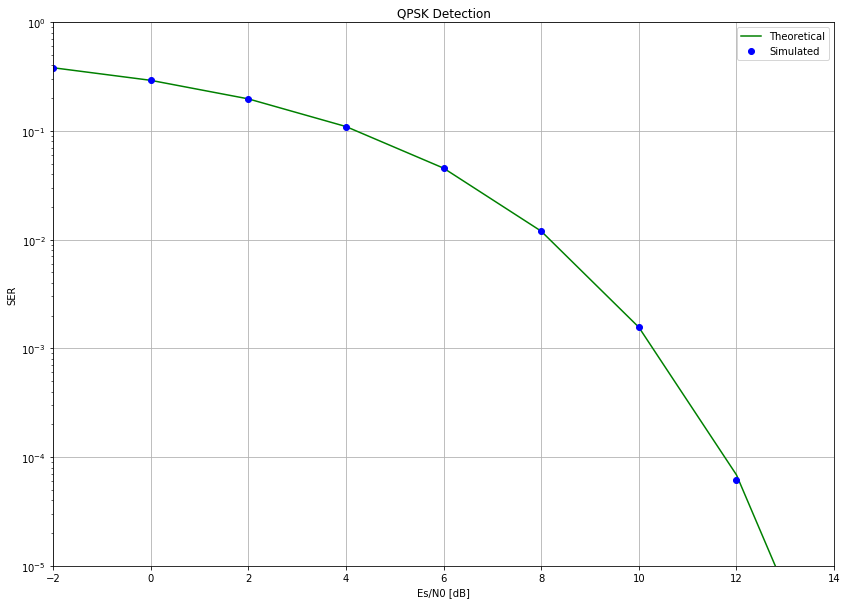

In [6]:
# Plot Es/N0 versus SER values.
fig = plt.figure(figsize=(14,10))
plt.plot(EsN0dB, SER_theo, 'g', label='Theoretical')
plt.plot(EsN0dB, SER_simu, 'bo', label='Simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('QPSK Detection')
plt.legend()
plt.xlim([-2, 14])
plt.ylim([1e-5, 1])
plt.show()